# Homework 5 - The eternal significance of publications and citations!

#### Group 15 <br>

<div style="float: left;">
    <table>
        <tr>
            <th>Student</th>
            <th>GitHub</th>
            <th>Matricola</th>
            <th>E-Mail</th>
        </tr>
        <tr>
            <td>André Leibrant</td>
            <td>JesterProphet</td>
            <td>2085698</td>
            <td>andre.leibrant@gmx.de</td>
        </tr>
        <tr>
            <td>Gianluca Procopio</td>
            <td>gianluca-24</td>
            <td>1942103</td>
            <td>procopio.1942103@studenti.uniroma1.it</td>
        </tr>
        <tr>
            <td>Susanna Bravi</td>
            <td>susannabravi</td>
            <td>1916681</td>
            <td>bravi.1916681@studenti.uniroma1.it</td>
        </tr>
    </table>
</div>

#### Import Libraries and Modules

In [84]:
import ast
import csv
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random
from tabulate import tabulate
from collections import deque

#### Constants

In [31]:
CIT_GRAPH = 'citation'
COLLAB_GRAP = 'collaboration'

## 1. Data
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset).

### Graphs setup
Based on the available data, you will create two graphs to model our relationships as follows:

1. **Citation graph:** This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. **Collaboration graph:** This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1. Identify the top **10,000 papers** with the <u>highest number of citations</u>.


2. Then the **nodes** of your graphs would be as follows:

    **Citation graph:** you can consider each of the papers as your nodes

    **Collaboration graph:** the authors of these papers would be your nodes


3. For the **edges** of the two graphs, you would have the following cases:

    **Citation graph:** only consider the citation relationship between these 10,000 papers and ignore the rest.

    **Collaboration graph:** only consider the collaborations between the authors of these 10,000 papers and ignore the rest.
    
---

We decided to read the large JSON file line by line and save the paper `id` with corresponding `n_citation` in a list.

---

In [ ]:
# File path for papers json file
file_path = "data.json"

# List to store paper information
papers = []

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for line_number, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Extract the id and number of citations (set to 0 if doesn't exist)
                paper_id = data["id"]
                paper_citations = data.get("n_citation", 0)

                # Append the information to the list
                papers.append({"id": paper_id, "n_citations": paper_citations})
                
            except:
                pass

---

In the next step we sort the list by `n_citations`, extract the top 10,000 entries and convert the id key values to a list.

---

In [ ]:
# Sort the list based on the number of citations
papers.sort(key=lambda paper: paper["n_citations"], reverse=True)

# Extract the top 10000 entries
top_10000_papers = papers[:10000]

# Convert id key values to list
paper_ids = [paper["id"] for paper in top_10000_papers]

---

Finally, we are going to iterate through the JSON file again and only extract the papers which are inside the top 10,000 list.

---

In [7]:
# Initialize an empty Pandas DataFrame
df_top_10000_papers = pd.DataFrame()

# Open the papers json file
with open(file_path, "r") as file:
    
    # Iterate through every line of the file
    for _, line in enumerate(file):
        
        # Remove the leading comma
        if line.startswith(","):
            line = line[1:]
        
        # Skip the opening and ending braket
        if len(line) > 2:
            
            # Skip lines that have non-readable characters
            try:
            
                # Parse the json line
                data = json.loads(line)

                # Only append if the id is from the top 10000 papers list
                if data["id"] in paper_ids:

                    # Load the json string into a temporary Pandas DataFrame
                    tmp_df = pd.read_json(line, lines=True)

                    # Append the temporary DataFrame to the main DataFrame
                    df_top_10000_papers = pd.concat([df_top_10000_papers, tmp_df], ignore_index=True)
            
            except:
                pass

---

We save the final result inside a CSV file, so that we don't have to always rerun the previous steps.

---

In [9]:
# Save results in CSV file
df_top_10000_papers.to_csv("top_10000_papers.csv", index=False)

---

We read the results inside the CSV file into a Pandas DataFrame for creating the citation and collaboration graphs.

---

In [3]:
# Read results from CSV file
df_top_10000_papers = pd.read_csv("top_10000_papers.csv")

---

First, we are going to create the citation (direct) graph using the paper's citation relationships. For this we extract all unique values between paper `ids` and `references` (which we convert from a string to a list of integers) and save the results inside `all_nodes`. Then we iterate through every paper, add the node if it is inside `all_nodes`, and add the edge between the `id` and `reference` if both are inside `all_nodes`.

---

In [5]:
# Drop all entries where the references field is empty
df_top_10000_papers = df_top_10000_papers.dropna(subset=["references"])

# Create an empty directed graph for the citations
citation_graph = nx.DiGraph()

# Get all unique paper ids
unique_ids = df_top_10000_papers["id"].unique()

# Extract all references and convert to a list of integers
reference_values = []
for references_str in df_top_10000_papers["references"]:
    references_list = ast.literal_eval(references_str)
    reference_values.extend(references_list)

# Get all unique values between both columns
all_nodes = set(unique_ids).union(set(reference_values))

# Add nodes and edges to the graph only for the nodes present in the file
for _, row in df_top_10000_papers.iterrows():
    paper_id = row["id"]
    references = ast.literal_eval(row["references"])
    
    # Add node if not already added
    if paper_id not in citation_graph.nodes:
        citation_graph.add_node(paper_id)
    
    # Add edges for references that are in the file
    for ref_id in references:
        if ref_id in all_nodes:
            citation_graph.add_edge(paper_id, ref_id)

---

In the next step we find the largest strongly connected component and save the result inside a subgraph.

---

In [6]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(citation_graph)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = citation_graph.subgraph(largest_component)

---

We quickly plot the subgraph:

---

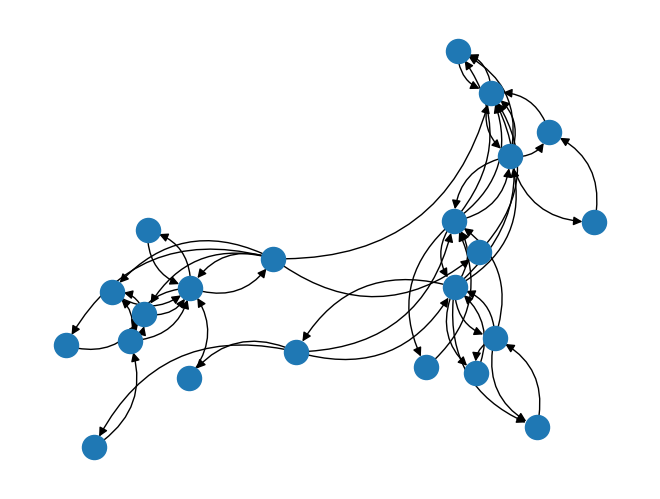

In [7]:
# Plot the subgraph
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph,
        pos,
        with_labels=False,
        arrowsize=13,
        connectionstyle="arc3, rad=0.4")

---

Next, we are going to create the collaboration (undirected and weigthed) graph using the collaborations of the paper's authors. For this we iterate through every paper and convert the authors list from a string to a list of dictionaries. Then we iterate through every pair of authors and add the nodes and edges if they don't exist yet. For the edge weight we decided to use the number of times two authors have collaborated. We are going to count the number of collaborations between each pair of authors and use that count as the weight.

---

In [8]:
# Create an empty undirected graph for the collaboration
collaboration_graph = nx.Graph()

# Iterate through each row in the DataFrame
for _, paper in df_top_10000_papers.iterrows():
    
    # Convert the string to a list of dictionaries
    authors_list = ast.literal_eval(paper["authors"])

    # Iterate through every pair of authors
    for i, author_i_dict in enumerate(authors_list):
        for j, author_j_dict in enumerate(authors_list[i+1:], start=i+1):
            
            # Retrieve author names
            author_i = author_i_dict["name"]
            author_j = author_j_dict["name"]
            
            # Initialize weight to 1
            weight = 1
            
            # Add nodes
            collaboration_graph.add_nodes_from([author_i, author_j])
            
            # Add edge if not already added and if yes, increase the weight by 1
            if not collaboration_graph.has_edge(author_i, author_j):
                collaboration_graph.add_edge(author_i, author_j, weight=weight)
                collaboration_graph[author_i][author_j]["titles"] = [paper["title"]]
            else:
                collaboration_graph[author_i][author_j]["weight"] += 1
                collaboration_graph[author_i][author_j]["titles"] += [paper["title"]]

In [9]:
# Get all connected components
connected_components = list(nx.connected_components(collaboration_graph))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph from the largest connected component
collaboration_subgraph = collaboration_graph.subgraph(largest_component)

---

**Note:** A graphical representation was not possible because the subgraph has 7324 nodes with 72875 edges!

---

# 2. Controlling system

## 2.1. Backend Implementation

---
### Functionality 1 - Graph Feature
---

This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below.
To retrieve these feautures we took advantages of some Networkx methods:
- The number of the nodes in the graph: graph.number_of_nodes();
- The number of the edges in the graph: graph.number_of_edges();
- The graph density: nx.density(graph);
- The graph degree distribution: for the udirected graph we can use the built in method nx.degree_histogram(graph); for the directed graph the things became a bit tricky: we had to compute the histogram manually by finding the higher degree among the inwards and outwards edges and then we created two list of zeros (of len max_degree+1) where each index represents a certain degree. In the end, we iterate over the values for both in_degree and out_degree and update the two arrays;
- The average degree of the graph: to compute the average degree we first computed the degree of each node (dict(graph.degree())) and then we compute the mean (sum(tot_degree.values()) / nodes_n);
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution): we computed the percentile and selected only the nodes whose degree was above the 95th percentile;
- Whether the graph is dense or sparse: we fixed a threshold (th=0.6) and we decided that a graph is dense if the ratio between the number of edges and the max number of edges is above the threshold, otherwise it is sparse. The max number of edges is n*(n-1) if the graph is directed while it is n*(n-1)/2 if the graph is undirected - _n_ is the number of nodes.

In [103]:
# functionality 1
def graph_features(graph,graph_name):
  nodes_n = graph.number_of_nodes()
  edge_n = graph.number_of_edges()
  density = nx.density(graph)
  if graph_name == COLLAB_GRAP:
    degree_dist = nx.degree_histogram(graph) # just use the built in method
  else: # compute the distribution of directed graph
    # compute the ingoing and the outgoing edges
    in_degrees = dict(graph.in_degree())
    out_degrees = dict(graph.out_degree())
    max_degree = max(max(in_degrees.values()), max(out_degrees.values()))
    # Create histograms for in-degrees and out-degrees
    # these lists helps us to save for each degree how many time we find it
    in_degree_hist = np.zeros(max_degree + 1, dtype=int)
    out_degree_hist = np.zeros(max_degree + 1, dtype=int)
    # manually create the histograms by counting for each degree how many time we found it
    for degree in in_degrees.values():
        in_degree_hist[degree] += 1
    for degree in out_degrees.values():
        out_degree_hist[degree] += 1
    # return it as  a tuple such that i can return just one variable
    degree_dist = (in_degree_hist,out_degree_hist)
  # compute the average degree
  tot_degree = dict(graph.degree())
  degree_avg = sum(tot_degree.values()) / nodes_n

  # compute hub, 95th percentile
  perc = np.percentile(list(tot_degree.values()),95)
  hub = [node_key for node_key, node_val in tot_degree.items() if node_val >= perc]
  # graph dense or sparse
  # max number of edges
  th = 0.6
  # compute the max number of edges paying attention if the graph is directed or undirected
  max_edges = nodes_n * (nodes_n - 1)/2 if graph_name == COLLAB_GRAP else nodes_n * (nodes_n - 1)
  is_dense = True if edge_n / max_edges >= th else False
  
  return nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense

name = int(input('Insert 0 for Citation Graph and 1 for Collaboration Graph: '))

In [104]:
name = int(input('Insert 0 for Citation Graph and 1 for Collaboration Graph: '))

if name == 0:
  nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense = graph_features(citation_graph,'citation')
else:
  collab_features = graph_features(collaboration_graph,'collaboration')

### Functionality 2 - Nodes' contribution

Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

In order to compute these centrality measurements we took advantage of some Networkx methods that allow us to compute all these centrality for the given node in input.

In [201]:
def nodes_contribution(graph,node,graph_name):
  btwn = nx.betweenness_centrality(graph)[node]
  pr = nx.pagerank(graph)[node]
  clsn = nx.closeness_centrality(graph,u=node)
  dc = nx.degree_centrality(graph)[node]
  return btwn,pr,clsn,dc

### Functionality 3 - Shortest ordered walk

Thus functionality works only on the Collaboration Graph, but despite it is a weighted graph, we used a BFS to commpute the shortest walk because if two authors collaborated to the same paper (hence, there is an edge between them) we assume that their distance is equal to 1. As a matter of fact, we are interested in the shortest walk and the weights does not represent distances: therefore we will compute the path with a BFS algorithm (Breadth First Search).

In this implementation of the BFS we kept track of the nodes through a queue which is initialized with a tuple containing the start node, the path from the start node (initialized with the start node itself), and an empty list for papers. Then there is the main loop that continues till the queue is empty: in each iteration we remove and return the first tuple of the queue (pop() method), we check if the current node is the end node (we've reached our destination), we mark the current node as visited and iterate over the neighbors of the current node. Each time we add a node to the queue, we keep up to date the path variable and the papers titles.  

This BFS is slightly revisited because beyond the path it returns also all the papers we crossed when looking for the right path.

In [211]:
def bfs_p(graph, start, end):
    
    # Initialize a queue with the start node
    queue = [(start, [start], [])]
    
    # Initialize an empty set to keep track of visited nodes
    visited = set()

    # Loop through until the end node is reached
    while queue:
        
        # Dequeue the current node to analyse and the current path from the queue
        current_node, path, papers = queue.pop(0)
        
        # Check if the current node is the end node
        if current_node == end:
            return path, papers
        
        # Mark the current node as visited
        visited.add(current_node)

        # Iterate through all neighbour nodes
        for neighbor in set(graph.neighbors(current_node)) - visited:
            
            # each edge between two authors represent a papers, therefore we need to retrieve the list of papers too
            titles = graph[current_node][neighbor]["titles"]
            
            # Enqueue the neighbor node and update the path
            queue.append((neighbor, path + [neighbor], papers + [titles[0]]))

    # Return None if no path was found
    return None, None

Below there is the main function we used to build the path. The main idea behind this function is that since we need to preserve the order of the given sequence of authors we will perform the BFS between 2 consecutive authors in the authors' sequence; with this idea, is more likely that our algorithm will visit the nodes in order. We later added a further check that makes us sure that the order is preserved.

In [212]:
def shortest_ordered_walk(graph, subsample):
    # initialize two empty arrays that will store the path to return and the papers
    path = []
    papers = []
    # the for loop goes from zero 
    for i in range(0, len(subsample)-1):
        # check if the nodes are in the subgraph we are considering. This will be useful only if we pick the subsample before we choose the top N.
        if subsample[i] not in graph.nodes():
            print("WARNING: This subsequence of nodes is not in the graph! \
                  Try to change N or check if the spelling is correct!")
            return None, None
        
        shortes_walk, titles = bfs_p(graph, subsample[i], subsample[i+1])
        # if no path was found, display a warning and return None, None
        if shortes_walk is None:
            print("WARNING: There is no such path!")
            return None, None
        else:
            # check if we didn't respect the order
            for auth in shortes_walk:
                try:
                    if auth in subsample[i+2:]:
                        print("WARNING: You didn't respect the order!")
                        return None, None
                except:
                    break
            # update the arrays to return
            if path == []:
                path = shortes_walk
                papers = titles
            else:
                path += shortes_walk[1:]
                papers += titles

    return path, papers

This is a code snippet we used to test our code. We decided to first extract the top N authors from the collaboration graph (N should be lower than the total number of nodes and we don't recommend to set it too high) and then, among the top N, we retrieved a random sample of size n (n lower than N) that will be our sequence of authors that we will look for.  

In order to find the top N we based our choice over the total number of collaboration (hence, the degree of the node), therefore we computed the degree for each node (each author) and sorted them based on the degree, in the end we selected the top N.  

Instead, when looking for the random sample, we selected all the top N nodes and extracted a random sample of size n, and we created a subgraph (with N nodes) over which we will run our algorithm.

In [13]:
# We choose an arbitrary N which has to be lower than the total number of nodes
N = 1000

degrees = dict(collaboration_graph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
graph_auth = collaboration_graph.subgraph(topN_authors_aux)

n = 7
random.seed(40)

subsample = random.sample(topN_authors_aux, n)

print("Subsample:")
for author in subsample:
    print(author)

path, papers = shortest_ordered_walk(graph_auth, subsample)

print('\nList of papers we crossed:')
for paper in papers:
    print(paper)

print('\nPath we found:')
for node in path:
    print(node)

Subsample:
Conor McMenamin
Sandra E. Orchard
Chris P Ponting
Tripti Gupta
Morana Vitezic
Jun Kawai
Ioannis Xenarios

List of papers we crossed:
InterPro in 2011: new developments in the family and domain prediction database
IntAct—open source resource for molecular interaction data
IntAct—open source resource for molecular interaction data
The InterPro Database, 2003 brings increased coverage and new features
The InterPro Database, 2003 brings increased coverage and new features
InterPro: the integrative protein signature database
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
Reference sequence (RefSeq) database at NCBI: current status, taxonomic expansion, and functional annotation
InterPro: the integrative protein signature database
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
A promoter-level mammalian expression atlas
The InterPro protein families database: the classification r

---
#### Chatgpt implementation
---

In [24]:
import queue

def bfs_shortest_walk(graph, start, end):
    visited = set()
    q = queue.Queue()
    q.put((start, [start]))

    while not q.empty():
        current, path = q.get()

        if current == end:
            # Found the destination
            return path, get_papers_along_path(graph, path)

        visited.add(current)

        for neighbor in graph.neighbors(current):
            if neighbor not in visited and neighbor == path[len(path) - 1]:
                # Preserve order
                q.put((neighbor, path + [neighbor]))

    return None, None

def shortest_ordered_walk_chatGPT(graph, subsample):
    path = []
    papers = []

    for i in range(len(subsample) - 1):
        current_author = subsample[i]
        next_author = subsample[i + 1]

        if current_author not in graph.nodes():
            print("WARNING: This subsequence of nodes is not in the graph! \
                  Try to change N or check if the spelling is correct!")
            return

        shortest_walk, titles = bfs_shortest_walk(graph, current_author, next_author)

        if shortest_walk is None:
            print("WARNING: There is no such path!")
            return None, None

        if path == []:
            path = shortest_walk
            papers = titles
        else:
            # Skip the first node to avoid duplicates
            path += shortest_walk[1:]
            papers += titles

    return path, papers

def get_papers_along_path(graph, path):
    papers = []
    for i in range(len(path) - 1):
        papers.extend(graph[path[i]][path[i + 1]]['titles'])
    return papers

To test this code we used the same kind of code snippet we used in other implementations.

In [26]:
N = 1000

degrees = dict(collaboration_graph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
graph_auth = collaboration_graph.subgraph(topN_authors_aux)

n = 7
random.seed(40)

subsample = random.sample(topN_authors_aux, n)

print("Subsample:")
for author in subsample:
    print(author)

path, papers = shortest_ordered_walk_chatGPT(graph_auth, subsample)

print('\nList of papers we crossed:')
for paper in papers:
    print(paper)

print('\nPath we found:')
for node in path:
    print(node)

Subsample:
Conor McMenamin
Sandra E. Orchard
Chris P Ponting
Tripti Gupta
Morana Vitezic
Jun Kawai
Ioannis Xenarios

Path we found:


TypeError: 'NoneType' object is not iterable

ChatGPT implementation is not working...   
We wrote a detailed prompt reporting the input, the desidered output and your indications. In the first place it didn't understand well the problem, therefore we showed it our implementation of the code and we asked for another solution more efficient but it couldn't give us any.            
We set a seed and used the same input in order to have a comparison between the 2 implementations.              
Its implementation is of course similar to ours but the bfs is implemented through a Queue, this can be a reasonable way to implement the BFS but in this case it doesn't work and so it doesn't find the shortest path.


### Functionality 4 - Disconnecting Graphs

Here we implemented the minimum cut algorithm to disconnect two specified nodes and we used a BFS to find paths between the nodes and then iteratively removes edges along these paths until there is no longer a path between the two nodes.  
This is very similar to our previous implementation but we don't need the papers' title this time.

In [ ]:
def bfs(graph, start, end):
    visited = set()
    # use a deque to implement the bfs
    queue = deque([(start, [])])

    while queue:
        current, path = queue.popleft()
        if current not in visited:
            visited.add(current)
            path = path + [current]
            # check if you reached your 
            if current == end:
                return path
            # analyze the neighbors
            for neighbor in graph[current]:
                if neighbor not in visited:
                    queue.append((neighbor, path))
    # return None if no path is found
    return None

In each iteration we call the BFS and look for all the possible paths. Every time we find a path we iterate over it and 
we analyze the path by taking pairs of consecutive nodes (two consecutive nodes made a edge).  

Therefore, once checked that that edge actually exists, we retrieve the data we care (the weight) and we remove the edge (we used the remove_edge function).

In [ ]:
def min_cut_edges(graph, node_a, node_b):
    # values to return initialized to zero
    removed_edges = 0
    total_weight = 0
    # main loop that will iterate till there are no more paths
    while True:
        path = bfs(graph, node_a, node_b) # look for the path
        if not path:
            print("The nodes are disconnected")
            break  # no path between the nodes, break the loop

        # iteareate over the found path and break it (one edge per time)
        for i in range(len(path) - 1):
            node1, node2 = path[i], path[i+1]

            # remove the edge between nodes
            if graph.has_edge(node1, node2):
                # get the weight
                edge_data = graph.get_edge_data(node1, node2)
                if edge_data is not None and "weight" in edge_data:
                    total_weight += edge_data["weight"] # update the removed weight
                # remove the edge and update the counter
                graph.remove_edge(node1, node2)
                removed_edges += 1

    return total_weight, removed_edges

To test our code we select 2 random authors out of the top N (N arbitrary chosen) based on their degrees.

In [247]:
N = 1000
degrees = dict(collaboration_subgraph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
subgraph_auth = collaboration_subgraph.subgraph(topN_authors_aux)
n = 2
subsample = random.sample(topN_authors_aux, n)
cnt = min_cut_edges(collaboration_graph,subsample[0],subsample[1])
print('Total weight removed: ', cnt[0])
print('Total number of edges removed: ', cnt[1])

The nodes are disconnected
(261, 215)


Notice that of course, regardless the input, the total weight removed will be higher or at least the same as the number of edges removed.

---
### Functionality 5 - Extracting Communities
---

Extracting communities from a graph refers to the process of identifying groups of nodes that are more densely connected with each other than with the rest of the nodes in the graph. Hence, a community is a subset of nodes with an higher connectivity compared to their connectivity with other nodes.  

In our implementation we try to find communities by iteratively removing edges with high betweenness centrality (i.e. edges that connect different parts of the graph).

In this case we need in input a full connected graph, hence we will work with the *citation_subgraph*; in fact we made a check over the number of connected components that if it's greater than 1 will end the function right away.
Moreover, our implementation requires that the input graph is undirected, so we need to transform it. 

Given that our implementation is based on the edge betweenness, we will compute the betweennes for each edge, we will sort them in descending order and then we will iteratively remove edges with the highest betweenness until the graph has more than just one connected component.  

In order to check if the two given papers ended up in the same community we first list all the communities (create a list with all the connected components) and then we iterate over the communities and check if the two papers are in the same community.

In the end we are request to return the number of removed edges too and so we first computed the number of nodes (through the Networkx method) at the start of the function and then we compute the difference when returning. 

In [ ]:
def extracting_communities(graph, p1, p2):
    # We need an undirected graph
    graph_copy = graph.to_undirected()

    if nx.number_connected_components(graph_copy) > 1:
        print("The graph is not full connected!")
        return 0,[],False
    
    # Calculate the initial number of edges
    num_edges_start = graph_copy.number_of_edges()

    # Calculate betweenness centrality for each edge
    edge_betweenness = nx.edge_betweenness_centrality(graph_copy)

    # Sort edges by betweenness centrality in descending order
    sorted_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
    
   
    # Remove edges until the graph has more than one connected component
    while nx.number_connected_components(graph_copy) == 1:
        edge_to_remove = sorted_edges.pop(0)[0]
        graph_copy.remove_edge(*edge_to_remove)

    # Find connected components as communities
    communities = list(nx.connected_components(graph_copy))

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any({p1, p2} <= community for community in communities)

    # Calculate the minimum number of edges removed
    num_edges_end = graph_copy.number_of_edges()
    # return a copy too that allows us to propery plot
    return num_edges_start-num_edges_end, communities, same_community, graph_copy 


Given that we need a full connected graph, we are using the citation subgraph, which is full connected but has only 22 nodes. For the sake of the test we choose 2 random papers among all the nodes.

In [ ]:
# number of nodes we want to analyze
n = 2
subsample = random.sample(list(citation_subgraph.nodes), n)
print("Papers we want:",subsample[0],subsample[1])
min,cm,is_cm,g_copy = extracting_communities(citation_subgraph.copy(),subsample[0],subsample[1])
print("Edges to eliminate:",min)
print("Number of communities:",len(cm))
print("Are the paper in the same community?",is_cm)

Number of nodes: 22
Papers we want: 2092654472 2152761983


The graph is not connected
Edges to eliminate: 0
Number of communities: 0
Are the paper in the same community? False


## 2.2. Frontend Implementation

---
#### Visualization 1 - Visualize graph features
---               

In [169]:
def visualize_basic(graph,graph_name):
  nodes_n,edge_n,density,degree_dist,degree_avg,hub,is_dense = graph_features(graph,graph_name)
  if is_dense == 0:
    is_dense = 'Sparse'
  else:
    is_dense = 'Dense'
  data = {"Number of nodes": nodes_n,"Number of edges": edge_n,"Density": density,"Average degree": degree_avg,"Dense or Sparse": is_dense}
  df = pd.DataFrame(data, index =[0])
  formatted_df = df.style.format(precision=3, thousands=".", decimal=",").format_index(str.upper, axis=1)
  print("------------------------------------TABLE OF STATISTICS------------------------------------")
  display(formatted_df)
  print("\n")
  print("------------------------------------TABLE OF HUBS-----------------------------------------")
  data_hub = pd.DataFrame({"HUB NODES" : hub})
  display(data_hub)
  if graph_name == COLLAB_GRAP:
    #Plot depicting the number of collaborations of the author 
    df_degree = pd.DataFrame({'Degree': range(len(degree_dist)), 'Count': degree_dist})
    # To not have 0 values otherwise the log scale will not work
    df_degree_filtered = df_degree[df_degree['Count'] > 0]
    print("\n")
    print("------------------------------------PLOT OF THE DEGREE------------------------------------")
    plt.figure(figsize=(6, 5))
    plt.bar(df_degree_filtered['Degree'], df_degree_filtered['Count'], log=True, width=3, color='#3D52D5', alpha=1)
    plt.title('Degree Distribution - Log Scale')
    plt.xlabel('Degree')
    plt.ylabel('Count (Log Scale)')
    plt.show()
  elif graph_name == CIT_GRAPH:
    in_deg , out_deg = degree_dist 
    df_degree_in = pd.DataFrame({'Degree': range(len(in_deg)), 'Count': in_deg})
    # To not have 0 values otherwise the log scale will not work
    df_degree_in_filtered = df_degree_in[df_degree_in['Count'] > 0]
    # Plot con scala logaritmica
    print("\n")
    print("-----------------------------------------------------------PLOT OF THE DEGREE-----------------------------------------------------------")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Modifica la dimensione se necessario
    df_degree_out = pd.DataFrame({'Degree': range(len(out_deg)), 'Count': out_deg})
    # To not have 0 values otherwise the log scale will not work
    df_degree_out_filtered = df_degree_out[df_degree_out['Count'] > 0]
    # Plot sul primo asse
    axs[0].bar(df_degree_in_filtered['Degree'], df_degree_in_filtered['Count'], log=True, width=3, color='#3D52D5', alpha=1)
    axs[0].set_title('Inward Degree Distribution - Log Scale')
    axs[0].set_xlabel('Inward Degree')
    axs[0].set_ylabel('Count (Log Scale)')
    axs[1].bar(df_degree_out_filtered['Degree'], df_degree_out_filtered['Count'], log=True, width=4, color='#3D52D5', alpha=1)
    axs[1].set_title('Outward Degree Distribution - Log Scale')
    axs[1].set_xlabel('Outward Degree')
    axs[1].set_ylabel('Count (Log Scale)')
  return 

------------------------------------TABLE OF STATISTICS------------------------------------


,NUMBER OF NODES,NUMBER OF EDGES,DENSITY,AVERAGE DEGREE,DENSE OR SPARSE
0,99.914,187.027,"0,000","3,744",Sparse




------------------------------------TABLE OF HUBS-----------------------------------------


,HUB NODES
0,1699105
1,1604454960
2,1660562555
3,2109394932
4,2151511199
...,...
5037,2896457183
5038,2897840903
5039,2912601938
5040,2913535645




-----------------------------------------------------------PLOT OF THE DEGREE-----------------------------------------------------------


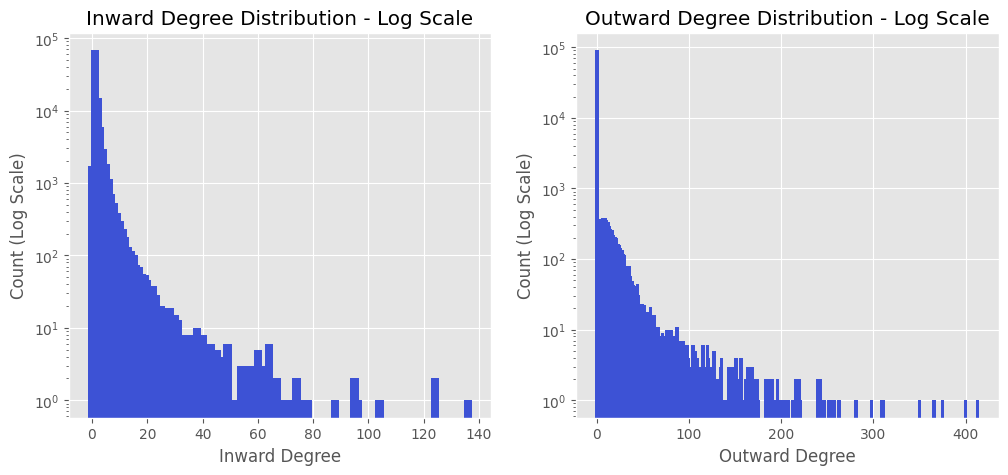

In [170]:
visualize_basic(citation_graph,CIT_GRAPH)

---
#### Visualization 2 - Visualize the node's contribution
---        

In [202]:
def visualize_centrality(graph,node,graph_name):
    btwn,pr,clsn,dc = nodes_contribution(graph,node,graph_name)
    data = {"Betweenness Centrality": btwn,"Pagerank": pr,"Closeness Centrality": clsn,"Degree Centrality": dc}
    df = pd.DataFrame(data, index =[0])
    formatted_df = df.style.format(precision=3, thousands=".", decimal=",").format_index(str.upper, axis=1)
    display(formatted_df)

In [207]:
print("------------------------------- TABLE OF CENTRALITIES -------------------------------")
visualize_centrality(citation_subgraph,2139212933,'citation')

------------------------------- TABLE OF CENTRALITIES -------------------------------


,BETWEENNESS CENTRALITY,PAGERANK,CLOSENESS CENTRALITY,DEGREE CENTRALITY
0,"0,048","0,037","0,219","0,238"


---
#### Visualization 3 - Visualize the shortest-ordered route
---

In [252]:
def visualize_shortest_ordered_route(graph,subsample,N,n):
    degrees = dict(collaboration_graph.degree())
    topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
    topN_authors_aux = [el[0] for el in topN_authors]
    graph_auth = collaboration_graph.subgraph(topN_authors_aux)
    path, papers = shortest_ordered_walk(graph_auth, subsample)
    print('\nList of papers we crossed:')
    for paper in papers:
        print(paper)
    font_size = 8  
    lista_edge = [(path[i], path[i+1]) for i in range(len(path)-1)]
    edge_colors = ['#3D52D5' if (u, v) in lista_edge or (v, u) in lista_edge else 'lightgray' for u, v in graph_auth.edges()]

    # Utilizza una disposizione statica per posizionare i nodi
    pos = nx.circular_layout(graph_auth)  # Puoi provare anche con nx.shell_layout(graph_auth)

    nx.draw(graph_auth, with_labels=True, font_size=font_size, edge_color=edge_colors, node_color="orange", pos=pos)
    plt.title('Shortest Path')

    edge_labels = {(u, v): i + 1 for i, (u, v) in enumerate(zip(path[:-1], path[1:]))}
    nx.draw_networkx_edge_labels(graph_auth, pos=pos, edge_labels=edge_labels)
    plt.show()

In [257]:
visualize_shortest_ordered_route(collaboration_subgraph,random.sample(topN_authors_aux, n),20,5)


List of papers we crossed:


TypeError: 'NoneType' object is not iterable

---
#### Visualization 4 - Visualize the disconnected graph
---

We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:

Print the number of the links that should be disconnected
Plot the original graph
Plot the graph after removing the links and identify the two nodes

In [ ]:
def visualize_disconnected_graph(graph,node_a,node_b,N):
    degrees = dict(graph.degree())
    topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
    topN_authors_aux = [el[0] for el in topN_authors]
    subgraph_auth = graph.subgraph(topN_authors_aux)
    cnt = min_cut_edges(graph,node_a,node_b)

In [250]:
def min_cut_edges(graph, node_a, node_b):
    removed_edges = 0
    total_weight = 0

    while True:
        path = bfs(graph, node_a, node_b)
        if not path:
            print("The nodes are disconnected")
            break  # No path found between A and B, break the loop

        # Cut the graph along the found path
        for i in range(len(path) - 1):
            node1, node2 = path[i], path[i+1]

            # Remove the edge between node1 and node2
            if graph.has_edge(node1, node2):
                # Get the weight of the removed edge
                edge_data = graph.get_edge_data(node1, node2)
                if edge_data is not None and "weight" in edge_data:
                    total_weight += edge_data["weight"]

                graph.remove_edge(node1, node2)
                removed_edges += 1

    return total_weight, removed_edges

In [251]:
N = 50
degrees = dict(collaboration_subgraph.degree())
topN_authors = sorted(degrees.items(),key=lambda x:x[1],reverse=True)[:N]
topN_authors_aux = [el[0] for el in topN_authors]
subgraph_auth = collaboration_subgraph.subgraph(topN_authors_aux)
n = 2
subsample = random.sample(topN_authors_aux, n)
cnt = min_cut_edges(collaboration_graph,subsample[0],subsample[1])
print(cnt)

The nodes are disconnected
(519, 519)


---
#### Visualization 5 - Visualize the communities
---

- Print the number of links that should be removed to have the communities  
- A table depicting the communities and the papers that belong to each community  
- Plot the original graph  
- Plot the graph showing the communities in the network  
- Plot the final graph and identify the community/communities of Paper_1 and Paper_2  

In [ ]:
n = 2
subsample = random.sample(list(citation_subgraph.nodes), n)
min_edge,cm,is_cm,g_copy = extracting_communities(citation_subgraph.copy(),subsample[0],subsample[1])

Number of links that should be removed to have the communities:

In [ ]:
print("Edges to eliminate:",min_edge)

A table depicting the communities and the papers that belong to each community. Here we showed only 4 elements per row in order to keep the plot tidy, but in the first row there are actually 21 nodes to display. Given that in the second community there is just one element, we find this the better and cleaner way to plot it.

In [ ]:
cm_2 = [list(community)[:4] + ['...'] if len(community) > 4 else list(community) for community in cm]

df = pd.DataFrame({"Index": range(len(cm_2)), "Set": cm_2})

table = tabulate(df, headers='keys', tablefmt='pretty', showindex=False)
print(table)

Here we plot the original graph:

In [ ]:
nx.draw(citation_subgraph)

Then we plot the graph showing the communities:

In [ ]:
pos = nx.spring_layout(citation_subgraph)  # You can use other layout algorithms
node_colors = [community_id for community_id, nodes in enumerate(cm) for node in nodes]

nx.draw(citation_subgraph, pos, node_color=node_colors, cmap=plt.cm.rainbow)

Plot the final graph and identify the community/communities of Paper_1 and Paper_2.
To properly display the choosen nodes we highlighted them witha different color and to mark the different communities we added a label woth the community ID (we enumerated the community such that each community has a serial number).

In [ ]:
pos = nx.spring_layout(g_copy)
node_labels = {node: f'Cm.{community_id}' for community_id, nodes in enumerate(cm) for node in nodes}

node_colors = ['red' if node in subsample else 'blue' for node in g_copy.nodes]

nx.draw(g_copy,pos,node_color=node_colors, cmap=plt.cm.rainbow,labels=node_labels)

## 4. Command Line Question (CLQ)
In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted graph** that you have previously created: **Citation graph**:

---

Before solving the questions in the Command Line we find the largest strongly connected component and save the subgraph inside a file which we are going to use in the Command Line. We decided to work on a subgraph for computation time reasons.

In [ ]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(citation_graph)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = citation_graph.subgraph(largest_component)

---

We quickly plot the subgraph:

---

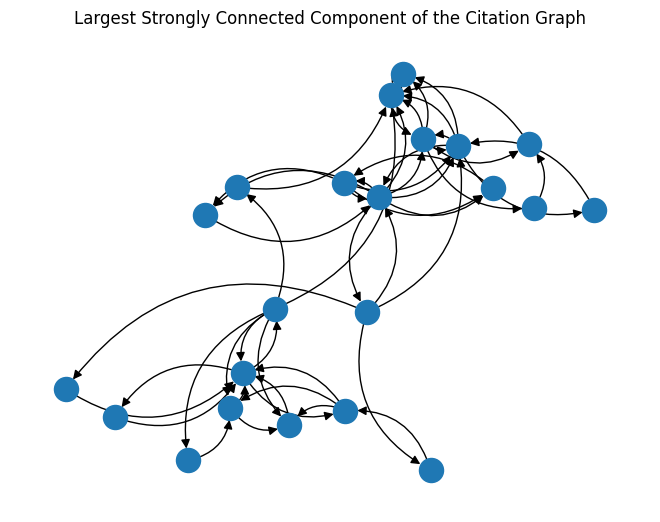

In [ ]:
# Plot the subgraph
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph,
        pos,
        with_labels=False,
        arrowsize=13,
        connectionstyle="arc3, rad=0.4")
plt.title("Largest Strongly Connected Component of the Citation Graph")
plt.show()

---

At last we save the subgraph in a file.

---

In [ ]:
nx.write_edgelist(citation_subgraph, "citation_subgraph.edgelist", data=False)

---

The shell script is saved in the file `CommandLine.sh`. First you need to navigate to the file where the `scitation_subgraph.edgelist` file is saved by using the `cd` command and then you can run the script with the `./CommandLine.sh` command (before that you have to make sure that it is executable by using the `chmod +x CommandLine.sh` command).

---

---

1. Is there any node that acts as an important "connector" between the different parts of the graph?

To identify a possible important connector we are going to calculate the betweenness centrality for each note:

```bash
# Calculate betweenness centrality for each node
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); print('\n'.join([f'{node} {centrality}' for node, centrality in nx.betweenness_centrality(citation_subgraph).items()]))" > betweenness_centrality.txt

# Sort nodes by betweenness centrality in descending order
sort -k2 -rn betweenness_centrality.txt > sorted_betweenness_centrality.txt

# Print the top connectors
head -n 10 sorted_betweenness_centrality.txt
```

![Screenshot1](Screenshot1.png)

---

**Conclusion:** The node with the paper id `2121127625` has a betweenness centrality score of 0.51 which indicates that, on average, half of the shortest paths in the graph pass through that specific node. The nodes with the paper ids `2032210760`, `2107890099`, and `1975846642` have a similar importance.

---

2. How does the degree of citation vary among the graph nodes?

Because not specified we are going to analyze the in-degrees and out-degrees of each node. In our context the in-degrees represent the number of times a paper has been cited and the out-degrees represent the number of citations made by that paper.

```bash
# Calculate in-degree and out-degree for each node and print the largest and smallest value for each type of degree
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); in_degrees = sorted(citation_subgraph.in_degree(), key=lambda x: x[1], reverse=True); out_degrees = sorted(citation_subgraph.out_degree(), key=lambda x: x[1], reverse=True); print(f'Largest In-Degree: {in_degrees[0][0]} {in_degrees[0][1]}'); print(f'Lowest In-Degree: {in_degrees[-1][0]} {in_degrees[-1][1]}'); print(f'Largest Out-Degree: {out_degrees[0][0]} {out_degrees[0][1]}'); print(f'Lowest Out-Degree: {out_degrees[-1][0]} {out_degrees[-1][1]}')"
```

![Screenshot2](Screenshot2.png)

---

**Conclusion:** Both type of degrees vary between 1 and 7.

---

3. What is the average length of the shortest path among nodes?

For this we can straight forward use the inbuild function `average_shortest_path_length` from `networkx`.

```bash
# Calculate average length of the shortest path among nodes
python -c "import networkx as nx; citation_subgraph = nx.read_edgelist('citation_subgraph.edgelist', create_using=nx.DiGraph()); average_shortest_path = nx.average_shortest_path_length(citation_subgraph); print(f'Average Shortest Path Length: {average_shortest_path}')"
```

![Screenshot3](Screenshot3.png)

---

**Conclusion:** The average length of the shortest path is 4.24 nodes.

---